<a href="https://colab.research.google.com/github/claire-dickerson/guestlecture/blob/main/Mini_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentence embeddings

After the advent of BERT, the infamous contextualized word embedding that you've already learned about, came the creation of numerous other BERT-style models. One of these models is SBERT (sentence BERT), which leverages the BERT architecture to create semantically meaningful sentence embeddings that can be mathematically compared in a vector space. 

In this mini-lab, you will get to play around with some of the functions SBERT can be used for, including clustering and topic modeling.

This mini-lab is set up to work with English, but if you're feeling ambitious you can experiment with other languages. Multilingual models exist for at least 50 languages, and you can look through the [Hugging Face hub](https://huggingface.co/models) to see what monolingual models exist for other languages.

In [1]:
!pip install -U sentence-transformers

## Generate sentence embeddings

In [2]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

# Sentences to encode
sentences = ['Here you can include sentences to embed.',
    'Se pueden escribir las oraciones en casi cualquier idioma.',
    'Men kom ihåg att hålla listan någorlunda kort.']

# Generate sentence embeddings
embeddings = model.encode(sentences, convert_to_tensor=True)

# Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print()

Sentence: Here you can include sentences to embed.
Embedding: tensor([-0.0730, -0.0507, -0.0590,  0.0629, -0.1447, -0.0384,  0.0336, -0.0064,
        -0.0468, -0.0076, -0.0613, -0.0690,  0.0471, -0.0091, -0.0138, -0.0589,
        -0.0510, -0.0131, -0.0032,  0.0036, -0.0351, -0.0218,  0.0172, -0.0147,
        -0.0083, -0.0130, -0.0387, -0.0493,  0.0050,  0.0573, -0.1114,  0.0559,
         0.0192, -0.0752,  0.0114, -0.0343,  0.0053,  0.0249, -0.0082,  0.0449,
        -0.0141,  0.0099, -0.0039, -0.0131, -0.0336,  0.0174,  0.0288, -0.0151,
         0.0142,  0.0264, -0.0645, -0.0353,  0.0457,  0.0866, -0.0268,  0.0526,
         0.0218, -0.0703,  0.0212, -0.0092, -0.0188, -0.0090,  0.0225, -0.0149,
        -0.0174,  0.0320,  0.0254, -0.0020,  0.0085, -0.0091,  0.0261,  0.0497,
        -0.0066,  0.0376, -0.0894,  0.0095, -0.0098, -0.0125,  0.0217,  0.1003,
         0.0540, -0.0465, -0.0178,  0.0361,  0.0639,  0.0262, -0.0070,  0.0065,
         0.0105, -0.0098, -0.0090, -0.0367,  0.0887,  0.01

In [3]:
# Look at the size of the sentence embeddings
print(embeddings.shape)

torch.Size([3, 512])


When running `embeddings.shape`, you can see that we have three representations of size 512 from these sentences.

## Semantic textual similarity

We can then use these embeddings to compute how similar they are to each other. Since we have three embeddings in the same space, we can do this relatively simply by using cosine similarity.

In [4]:
# Adding a few more sentences for comparison
sentences2 = ['Y aquí tenemos algunas oraciones más.', 
              'Es sólo para que puedan ser comparadas.', 
              'Och de ska skrivas på olika språk också.',
              'And I will include some sentences of different lengths as well, so we can see how length affects the similarity.']
              
embeddings2 = model.encode(sentences2, convert_to_tensor=True)

In [5]:
from sentence_transformers import util

# Compute cosine similarity
cosine_scores = util.cos_sim(embeddings, embeddings2)

# Output the pairs with their score
for i in range(len(sentences)):
    print(f'Sentence 1: {sentences[i]} Sentence 2: {sentences2[i]} Score: {cosine_scores[i][i].item()}')
    print()

Sentence 1: Here you can include sentences to embed. Sentence 2: Y aquí tenemos algunas oraciones más. Score: 0.39608627557754517

Sentence 1: Se pueden escribir las oraciones en casi cualquier idioma. Sentence 2: Es sólo para que puedan ser comparadas. Score: 0.11861550807952881

Sentence 1: Men kom ihåg att hålla listan någorlunda kort. Sentence 2: Och de ska skrivas på olika språk också. Score: 0.13186991214752197



## Clustering

These embeddings can also be clustered now. However, just a few sentences is not very exciting, so we can download a few book chapters to use for clustering instead. 

In [6]:
!wget https://raw.githubusercontent.com/claire-dickerson/guestlecture/main/fine_literature.txt

--2022-05-23 11:41:26--  https://raw.githubusercontent.com/claire-dickerson/guestlecture/main/fine_literature.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143414 (140K) [text/plain]
Saving to: ‘fine_literature.txt.1’

fine_literature.txt 100%[===================>] 140.05K  --.-KB/s    in 0.01s   

2022-05-23 11:41:26 (11.4 MB/s) - ‘fine_literature.txt.1’ saved [143414/143414]



First some basic text processing

In [7]:
text = []
with open('fine_literature.txt') as infile: 
    for line in infile:
        line = line.strip()
        if line == '':
            continue
        else:
            text.append(line)

print(f'{len(text)} lines in corpus.')

1042 lines in corpus.


Then embedding the sentences. Calculating the semantic textual similarity of the texts is not necessary, but it can give us an insight into what our data looks like.

In [8]:
embeddings = model.encode(text, convert_to_tensor=True)

# Compute cosine similarities for corpus
cosine_scores = util.cos_sim(embeddings, embeddings)

# Find pairs with highest cosine similarity scores
pairs = []
for i in range(len(cosine_scores)-1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

# Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

# Print top 10 most similar pairs
for pair in pairs[:50]:
    i, j = pair['index']
    print(f"Sentence 1: {text[i]} \nSentence 2: {text[j]} \nScore: {pair['score'].item()}")
    print()

Sentence 1: "Yes." 
Sentence 2: "Yes." 
Score: 1.0000004768371582

Sentence 1: "Yes." 
Sentence 2: "Yes." 
Score: 1.0000004768371582

Sentence 1: "Yes." 
Sentence 2: "Yes." 
Score: 1.0000004768371582

Sentence 1: "No." 
Sentence 2: "No." 
Score: 1.0000003576278687

Sentence 1: "What?" 
Sentence 2: "What?" 
Score: 1.000000238418579

Sentence 1: Mom, 
Sentence 2: Mom, 
Score: 0.9999998211860657

Sentence 1: "Thanks." 
Sentence 2: "Thanks." 
Score: 0.9999997019767761

Sentence 1: "No." 
Sentence 2: "Nope." 
Score: 0.9948244094848633

Sentence 1: "No." 
Sentence 2: "Nope." 
Score: 0.9948244094848633

Sentence 1: "Yeah." 
Sentence 2: "Yes." 
Score: 0.9829349517822266

Sentence 1: "Yeah." 
Sentence 2: "Yes." 
Score: 0.9829349517822266

Sentence 1: "Yeah." 
Sentence 2: "Yes." 
Score: 0.9829349517822266

Sentence 1: "No." 
Sentence 2: "Yes." 
Score: 0.9242275953292847

Sentence 1: "No." 
Sentence 2: "Yes." 
Score: 0.9242275953292847

Sentence 1: "No." 
Sentence 2: "Yes." 
Score: 0.924227595329

We'll need UMAP to reduce the dimensionality of the embeddings for clustering, and HDBSCAN will be our clustering algorithm. 

**An important note is that due to how the UMAP algorithm works, the embeddings are not the same every time they are run, so you might receive slightly different results if you run the notebook multiple times.

In [9]:
try:
    import umap
except:
    !pip install umap-learn
finally:
    import umap

umap_embeddings = umap.UMAP(n_neighbors=10, 
                            n_components=3, 
                            metric='cosine').fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [10]:
try:
    import hdbscan
except:
    !pip install hdbscan
finally: 
    import hdbscan

cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

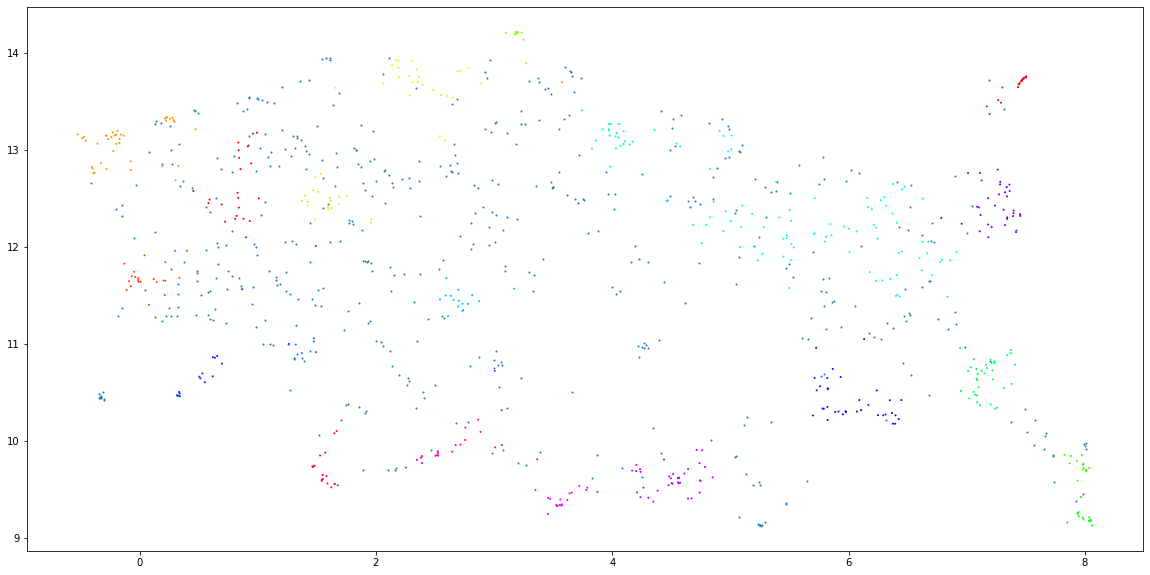

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
umap_data = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, s=1)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1, cmap='hsv_r')

We have some visualizations! We're only working with around 1000 lines, so the hyperparameters for UMAP and HDBSCAN are relatively low. If you try with more data, you might have to adjust the original UMAP embeddings and HDBSCAN clusters to retrieve more satisfying clusters.

Topic modeling---retrieving the influential words from each cluster---is a separate task, but we can at least take a look at five of the sentences from each cluster. 

In [12]:
clusters = {}

for i, label in enumerate(result['labels'].tolist()):
    if label in clusters:
        clusters[label].append(i)
    else:
        clusters[label] = [i]  

print(f"{len(clusters)-1} clusters were extracted from the texts\n")

for i in range(len(clusters)-1):
    print(f"Cluster {i}:")
    for j in range(5):
        print(f"{text[clusters[i][j]]}")
    print()

21 clusters were extracted from the texts

Cluster 0:
"I'm Mike."
"Hi, Mike."
"He's a weird guy." Mike lingered by me instead of heading to the dressing room. "If I were lucky enough to sit by you, I would have talked to you."
"Wow," Mike said. "It's snowing."
"You have fun with Mike," I encouraged.

Cluster 1:
"Bella," my mom said to me - the last of athousand times - before I goton the plane. "You don't have to do this."
"Don't worry about me," I urged. "It'll be great. I love you, Mom."
"My mother is part albino."
"How did your first day go, dear?" the receptionist asked maternally.
"Bella," my mom wrote...

Cluster 2:
"Really, Bella, the thing runs great. They don't build them like thatanymore."
"Aren't you Isabella Swan?" a male voice asked.
Isabella,
"Bella?" my father called out when he heard me on the stairs.
"Smells good, Bell."

Cluster 3:
"Who are they?" I asked the girl from my Spanish class, whose name I'd forgotten.
"That's Edward and Emmett Cullen, and Rosalie and Jasper